### Install Dependencies

In [ ]:
%pip install torch --quiet --quiet
%pip install coba --quiet --quiet
%pip install scipy --quiet --quiet
%pip install numpy --quiet --quiet
%pip install matplotlib --quiet --quiet
%pip install cloudpickle --quiet --quiet
%pip install sentence-transformers --quiet --quiet
%pip install ipywidgets --quiet --quiet

### TODO
+ Reference policy has all examples but only randomizes over the best for each example (this solve Gumbel being a bottleneck)

### Run Demo

In [14]:
import json
from typing import Sequence, Callable

import torch
import coba as cb
from sentence_transformers import SentenceTransformer

from AbstractClasses import ReferencePolicy

model = SentenceTransformer('all-MiniLM-L6-v2')

def embedder(items):
    if isinstance(items,str):
        return model.encode([items],convert_to_tensor=True)
    if isinstance(items,list):
        return model.encode([ i['instruction'] for i in items],convert_to_tensor=True)
    raise AssertionError()

class RandomizedSimilarity(ReferencePolicy):
    def __init__(self, 
        embedder: Callable, 
        examples: Sequence, 
        batch_size: int, 
        temperature:float,
        set_size:int) -> None:
        self._embedder = embedder
        self._embeddings = torch.nn.functional.normalize(embedder(examples))
        self._examples = examples
        self._batch_size = batch_size
        self._temperature = temperature
        self._set_size = set_size

    @property
    def params(self):
        return {'temp':self._temperature, 'sampler':'RandomizedSimilarity'}
    
    def sample(self, context):
        embedded_context = torch.nn.functional.normalize(self._embedder(context))
        similarities = embedded_context @ self._embeddings.T
        
        gumbel = torch.distributions.gumbel.Gumbel(0,1)
        gumbel_shape = torch.Size([self._batch_size, similarities.shape[1]])
        while True:
            gumbels = gumbel.sample(gumbel_shape)*self._temperature
            topks = torch.topk(similarities+gumbels,self._set_size,dim=1).indices
            yield [ [ self._examples[i] for i in row] for row in topks ]

class FewShotFixedStrategy:
    def __init__(self, sampler:ReferencePolicy) -> None:
        self._sampler = sampler
    @property
    def params(self):
        return self._sampler.params
    def predict(self, context, actions):
        return next(self._sampler.sample(context))[0], None
    def learn(self, context, actions, action, reward, probs, **kwargs):
        pass

class ZeroShotStrategy:
    def predict(self, context, actions):
        return [],None
    def learn(self, context, actions, action, reward, probs, **kwargs):
        pass

2023-07-20 21:49:12 -- pid-34248  -- Experiment Started
2023-07-20 21:49:14 -- pid-15436  -- Recording Evaluator 0 parameters... (0.01 seconds) (completed)
2023-07-20 21:49:14 -- pid-17540  -- Recording Learner 2 parameters... (0.0 seconds) (completed)
2023-07-20 21:49:16 -- pid-17540  -- Recording Environment 0 parameters... (0.0 seconds) (completed)
2023-07-20 21:49:16 -- pid-31532  -- Recording Learner 0 parameters... (0.0 seconds) (completed)
2023-07-20 21:49:17 -- pid-15436  -- Recording Learner 1 parameters... (0.0 seconds) (completed)
2023-07-20 21:49:18 -- pid-31532  -- Peeking at Environment 0... (1.67 seconds) (completed)
2023-07-20 21:49:19 -- pid-15436  -- Peeking at Environment 0... (1.89 seconds) (completed)
2023-07-20 21:49:19 -- pid-17540  -- Peeking at Environment 0... (1.98 seconds) (completed)
2023-07-20 21:55:19 -- pid-15436  -- Evaluating Learner 2 on Environment 0... (360.85 seconds) (completed)
2023-07-20 22:10:06 -- pid-31532  -- Evaluating Learner 1 on Environm

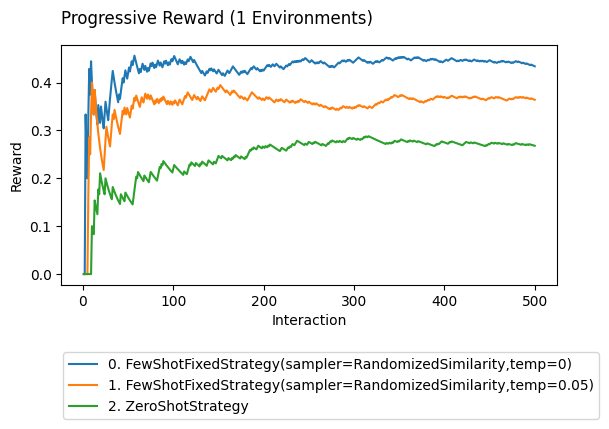

In [16]:
import torch
import coba as cb
from LetCatEnvironment import LetCatEnvironment

batch_size = 8
n_batches = 30

with open('LetCatTrain.jsonl',mode='rb') as f:
    examples = [ json.loads(line) for line in f ][:1000]

rs_00 = RandomizedSimilarity(embedder, examples, batch_size=1, temperature=.00, set_size=3)
rs_05 = RandomizedSimilarity(embedder, examples, batch_size=1, temperature=.05, set_size=3)

env = cb.Environments(LetCatEnvironment()).take(500)
lrn = [FewShotFixedStrategy(rs_00),FewShotFixedStrategy(rs_05),ZeroShotStrategy()]

result = cb.Experiment(env,lrn).run(processes=3)
result.plot_learners()

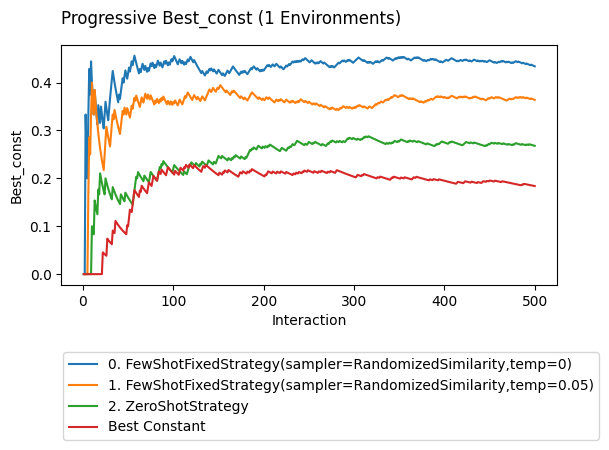

In [17]:
result.plot_learners(out=None)
result.where(learner_id=0).plot_learners(y='best_const',colors=3,labels='Best Constant')